# Preprocessing Dataset #2

In [1]:

## Import the data
import pandas as pd


In [2]:
# 1. Load the datasets into Pandas dataframes
names2=['A1-Time','A2','A3','A4','A5','A6','A7','A8','A9','LABEL']
dataset2 = pd.read_csv('shuttle_trn.csv', index_col=False, names=names2, sep=' ', engine='python')
print(dataset2)

       A1-Time  A2   A3  A4  A5  A6  A7  A8  A9  LABEL
0           50  21   77   0  28   0  27  48  22      2
1           55   0   92   0   0  26  36  92  56      4
2           53   0   82   0  52  -5  29  30   2      1
3           37   0   76   0  28  18  40  48   8      1
4           37   0   79   0  34 -26  43  46   2      1
...        ...  ..  ...  ..  ..  ..  ..  ..  ..    ...
43495       46   5   78   0  46   5  32  32   0      1
43496       37   0   79  -1  10   3  43  69  26      1
43497       48   0   78   3  46   0  30  32   2      1
43498       41   0   79   0  38 -25  38  40   2      1
43499       40  -3  100   0  38   0  61  62   2      1

[43500 rows x 10 columns]



## Clean the data

Data is complete, i.e., no missing cells
Attributes are undefined, therefore all will be kept and be given the same weight


## Visulization

Text(0.5, 1.0, 'LABEL')

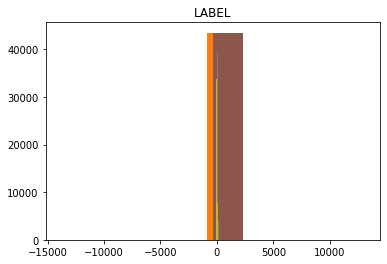

In [3]:
# Visualizing data to have a better idea of the data
# Plotting frequency of different attribute values since there are only 9 (+ 1 for assigned labels)
import matplotlib.pyplot as plt
plt.hist(dataset2['A1-Time'], histtype='bar')
plt.title("A1-Time")
plt.hist(dataset2['A2'], histtype='bar')
plt.title("A2")
plt.hist(dataset2['A3'], histtype='bar')
plt.title("A3")
plt.hist(dataset2['A4'], histtype='bar')
plt.title("A4")
plt.hist(dataset2['A5'], histtype='bar')
plt.title("A5")
plt.hist(dataset2['A6'], histtype='bar')
plt.title("A6")
plt.hist(dataset2['A7'], histtype='bar')
plt.title("A7")
plt.hist(dataset2['A8'], histtype='bar')
plt.title("A8")
plt.hist(dataset2['A9'], histtype='bar')
plt.title("A9")
plt.hist(dataset2['LABEL'], histtype='bar')
plt.title("LABEL")

## One-hot coding
# No need for one-hot coding since all attributes and labels are numerical values